# 15.456 - Assignment 8
## Niccolo Comati (945404758)

### Probelm 1


(a) Policy at T-2:
Maximum trade size: 0.7071
Minimum trade size: 0.2929
Mean trade size: 0.5000


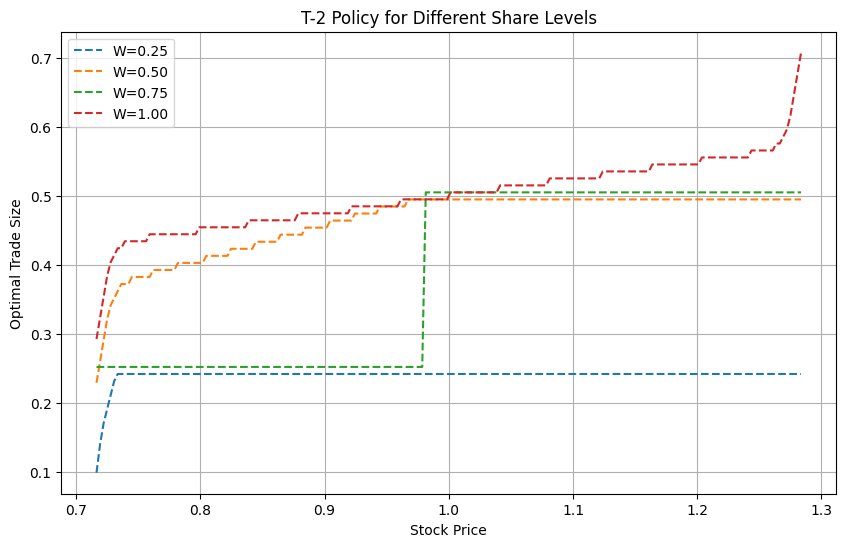


(b) Policy at t=T/2 with 50% shares remaining:
Maximum trade size: 0.4948
Minimum trade size: 0.0153
Mean trade size: 0.3018


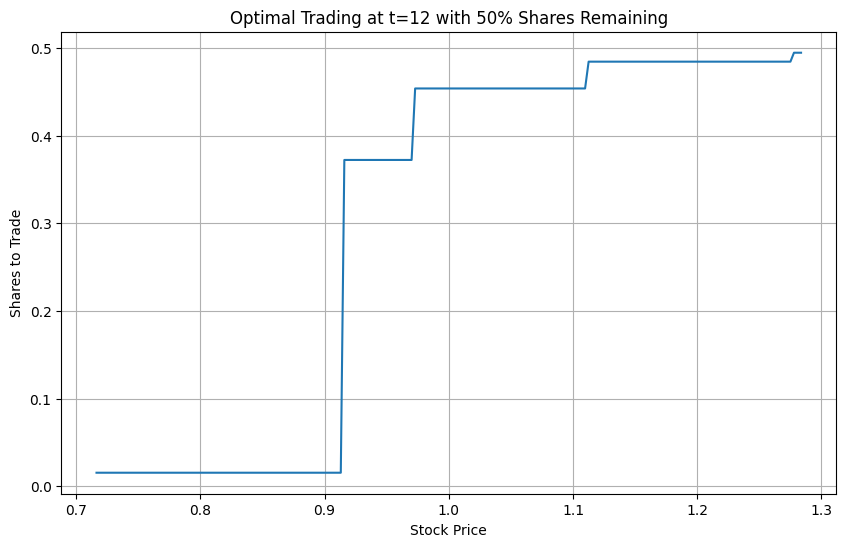


(c) Policy at t=T/2 and S=1:
Maximum trade size: 0.4540
Minimum trade size: 0.0000
Trade size at 50% shares: 0.4540


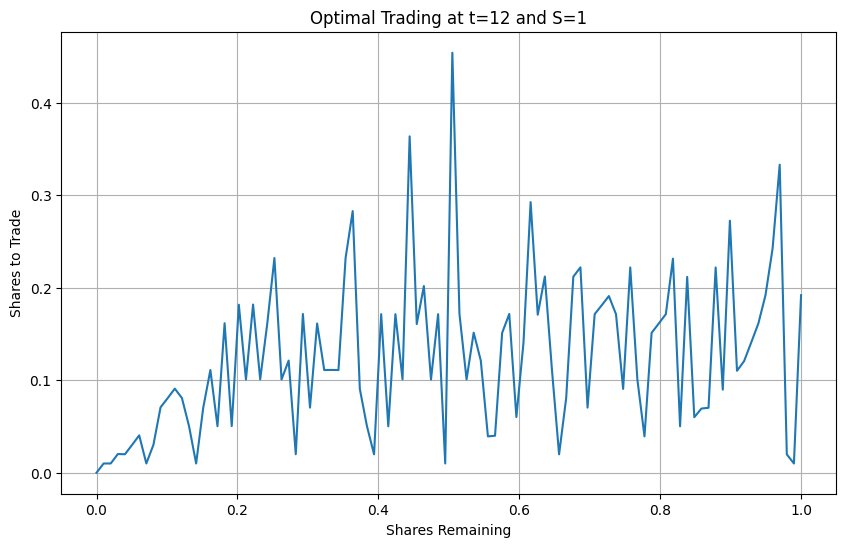


(d) Simulation Results:
Average Optimal Profit: 1.006167
Average Uniform Profit: 0.999417
Improvement: 0.68%
Standard deviation - Optimal: 0.021277
Standard deviation - Uniform: 0.025466

Rho Impact (ρ = 0.99):
With high ρ, the optimal strategy can better exploit price
predictability by timing trades according to mean-reverting dynamics.


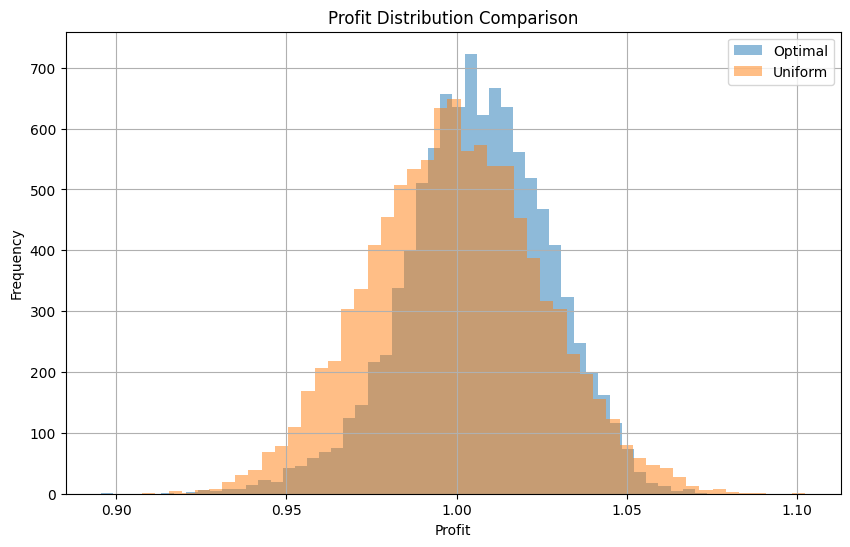

In [31]:
import numpy as np
import matplotlib.pyplot as plt

class OptimalExecutionSolver:
    def __init__(
        self,
        T: int = 24,
        S_bar: float = 1.0,
        rho: float = 0.99,
        sigma: float = 0.01,
        lambda_: float = 0.01,
        X_total: float = 1.0,
        N_price: int = 200,
        N_shares: int = 100,
        N_trades: int = 100,
        price_std_range: float = 4.0
    ):
        self.T = T
        self.S_bar = S_bar
        self.rho = rho
        self.sigma = sigma
        self.lambda_ = lambda_
        self.X_total = X_total
        
        # Calculate long-run price standard deviation
        self.price_std = sigma / np.sqrt(1 - rho**2)
        
        # Create grids
        self.S_grid = np.linspace(
            S_bar - price_std_range * self.price_std,
            S_bar + price_std_range * self.price_std,
            N_price
        )
        self.X_grid = np.linspace(0, X_total, N_shares)
        self.N_trades = N_trades
        
        # Initialize matrices
        self.V = np.zeros((T + 1, N_price, N_shares))
        self.policy = np.zeros((T, N_price, N_shares))
        
        # Compute transition matrix
        self.P = self._compute_transition_matrix()
    
    def _compute_transition_matrix(self):
        N = len(self.S_grid)
        P = np.zeros((N, N))
        
        for i, s_current in enumerate(self.S_grid):
            mean_next = self.rho * s_current + (1 - self.rho) * self.S_bar
            P[i, :] = np.exp(-0.5 * ((self.S_grid - mean_next) / self.sigma) ** 2)
            P[i, :] /= np.sum(P[i, :])
        
        return P
    
    def solve(self):
        self.V[self.T] = 0
        
        for t in range(self.T - 1, -1, -1):
            for i_s, s in enumerate(self.S_grid):
                for i_x, x in enumerate(self.X_grid):
                    if x == 0:
                        continue
                    
                    trades = np.linspace(0, x, self.N_trades)
                    values = np.zeros_like(trades)
                    
                    for k, trade in enumerate(trades):
                        reward = trade * (s - self.lambda_ * trade)
                        
                        if t < self.T - 1:
                            x_next_idx = np.searchsorted(self.X_grid, x - trade)
                            if x_next_idx < len(self.X_grid):
                                future_value = self.P[i_s] @ self.V[t + 1, :, x_next_idx]
                                values[k] = reward + future_value
                        else:
                            values[k] = reward
                    
                    best_k = np.argmax(values)
                    self.V[t, i_s, i_x] = values[best_k]
                    self.policy[t, i_s, i_x] = trades[best_k]
        
        return self.V, self.policy
    
    def simulate_paths(self, n_paths=10000, S0=None):
        if S0 is None:
            S0 = self.S_bar
            
        S = np.zeros((n_paths, self.T + 1))
        S[:, 0] = S0
        
        for t in range(self.T):
            epsilon = np.random.normal(0, self.sigma, n_paths)
            S[:, t + 1] = self.rho * S[:, t] + (1 - self.rho) * self.S_bar + epsilon
        
        uniform_trade = self.X_total / self.T
        optimal_profits = np.zeros(n_paths)
        uniform_profits = np.zeros(n_paths)
        
        for i in range(n_paths):
            x_remaining = self.X_total
            
            for t in range(self.T):
                s_idx = min(np.searchsorted(self.S_grid, S[i, t]), len(self.S_grid) - 1)
                x_idx = min(np.searchsorted(self.X_grid, x_remaining), len(self.X_grid) - 1)
                
                trade = self.policy[t, s_idx, x_idx]
                optimal_profits[i] += trade * (S[i, t] - self.lambda_ * trade)
                x_remaining -= trade
                
                uniform_profits[i] += uniform_trade * (S[i, t] - self.lambda_ * uniform_trade)
        
        return optimal_profits, uniform_profits

def main():
    # Initialize solver
    solver = OptimalExecutionSolver()
    V, policy = solver.solve()
    
    # (a) Policy at T-2
    print("\n(a) Policy at T-2:")
    t_minus_2_policy = policy[solver.T-2, :, -1]  # Full shares remaining
    print(f"Maximum trade size: {np.max(t_minus_2_policy):.4f}")
    print(f"Minimum trade size: {np.min(t_minus_2_policy):.4f}")
    print(f"Mean trade size: {np.mean(t_minus_2_policy):.4f}")
    
    plt.figure(figsize=(10, 6))
    share_levels = [0.25, 0.5, 0.75, 1.0]
    for w in share_levels:
        w_idx = np.searchsorted(solver.X_grid, w)
        plt.plot(solver.S_grid, policy[solver.T-2,:,w_idx], '--', label=f'W={w:.2f}')
    plt.title('T-2 Policy for Different Share Levels')
    plt.xlabel('Stock Price')
    plt.ylabel('Optimal Trade Size')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # (b) T/2 policy with 50% shares
    mid_t = solver.T // 2
    x_idx = len(solver.X_grid) // 2
    mid_policy = policy[mid_t, :, x_idx]
    
    print("\n(b) Policy at t=T/2 with 50% shares remaining:")
    print(f"Maximum trade size: {np.max(mid_policy):.4f}")
    print(f"Minimum trade size: {np.min(mid_policy):.4f}")
    print(f"Mean trade size: {np.mean(mid_policy):.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(solver.S_grid, mid_policy)
    plt.title(f'Optimal Trading at t={mid_t} with 50% Shares Remaining')
    plt.xlabel('Stock Price')
    plt.ylabel('Shares to Trade')
    plt.grid(True)
    plt.show()
    
    # (c) Policy vs shares at S=1
    s_idx = np.searchsorted(solver.S_grid, 1.0)
    shares_policy = policy[mid_t, s_idx, :]
    
    print("\n(c) Policy at t=T/2 and S=1:")
    print(f"Maximum trade size: {np.max(shares_policy):.4f}")
    print(f"Minimum trade size: {np.min(shares_policy):.4f}")
    print(f"Trade size at 50% shares: {shares_policy[len(solver.X_grid)//2]:.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(solver.X_grid, shares_policy)
    plt.title(f'Optimal Trading at t={mid_t} and S=1')
    plt.xlabel('Shares Remaining')
    plt.ylabel('Shares to Trade')
    plt.grid(True)
    plt.show()
    
    # (d) Simulation comparison
    optimal_profits, uniform_profits = solver.simulate_paths()
    
    print("\n(d) Simulation Results:")
    print(f"Average Optimal Profit: {np.mean(optimal_profits):.6f}")
    print(f"Average Uniform Profit: {np.mean(uniform_profits):.6f}")
    print(f"Improvement: {((np.mean(optimal_profits)/np.mean(uniform_profits) - 1)*100):.2f}%")
    print(f"Standard deviation - Optimal: {np.std(optimal_profits):.6f}")
    print(f"Standard deviation - Uniform: {np.std(uniform_profits):.6f}")
    print(f"\nRho Impact (ρ = {solver.rho}):")
    print("With high ρ, the optimal strategy can better exploit price")
    print("predictability by timing trades according to mean-reverting dynamics.")
    
    plt.figure(figsize=(10, 6))
    plt.hist(optimal_profits, bins=50, alpha=0.5, label='Optimal')
    plt.hist(uniform_profits, bins=50, alpha=0.5, label='Uniform')
    plt.xlabel('Profit')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title('Profit Distribution Comparison')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()

### Problem 2


(a) Plotting exercise boundary 60 days before maturity...


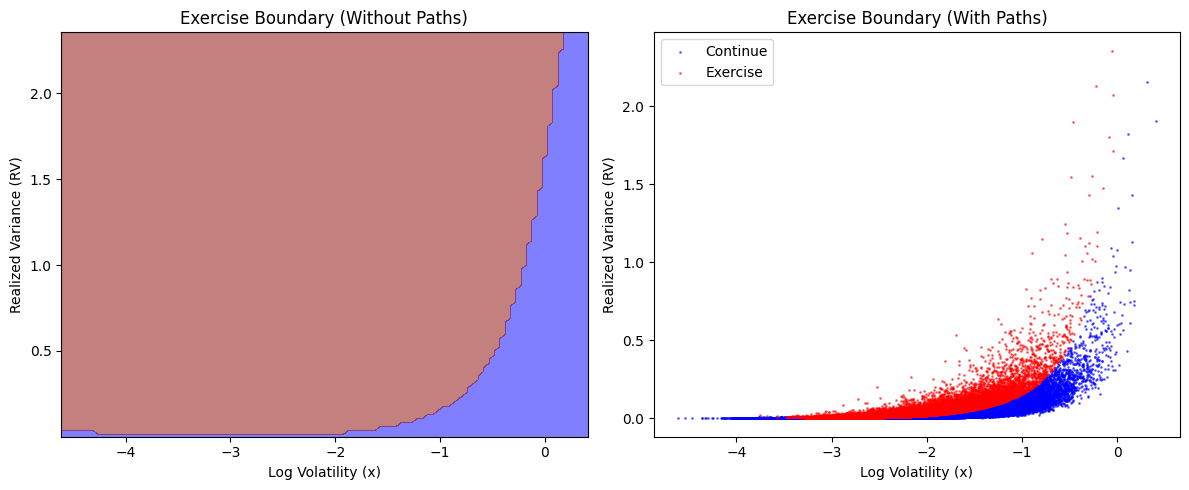


(b) Estimating market value of the payoff using 10,000 independent paths...
Option Value: 0.036580
95% Confidence Interval: (0.034399, 0.038761)


In [35]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

def simulate_sv_paths(S0, x0, x_bar, theta, gamma_x, rho, rF, muS, T, delta, Nsims):
    Nperiods = int(T/delta)
    S = np.full((Nsims, Nperiods + 1), S0)
    x = np.full((Nsims, Nperiods + 1), x0)
    
    S[:, 0] = S0
    x[:, 0] = x0
    
    for t in range(1, Nperiods + 1):
        eps_S, eps_v = np.random.normal(0, 1, (2, Nsims))
        vt = np.exp(x[:, t-1])
        eta_St = (muS - rF) / vt
        eta_x = -0.2
        
        x[:, t] = x[:, t-1] - theta * (x[:, t-1] - x_bar) * delta \
                 - (rho * eta_St + np.sqrt(1 - rho**2) * eta_x) * gamma_x * delta \
                 + gamma_x * np.sqrt(delta) * (rho * eps_S + np.sqrt(1 - rho**2) * eps_v)
        
        S[:, t] = S[:, t-1] * np.exp((rF - 0.5 * vt**2) * delta + vt * np.sqrt(delta) * eps_S)
    
    return S, x

def compute_realized_variance(S, window=10, delta=1/252):
    log_returns = np.diff(np.log(S), axis=1)
    RV = np.zeros(S.shape)
    
    for t in range(window, S.shape[1]):
        RV[:, t] = np.mean(log_returns[:, t-window:t]**2, axis=1) / delta
    
    return RV

def plot_exercise_boundary(params, t_plot=66):
    print("\n(a) Plotting exercise boundary 60 days before maturity...")
    
    # Simulation parameters
    S0, x0 = 1.0, np.log(0.1)
    K = 0.0001
    T = 126/252
    Nsims = 100000
    
    # Simulate paths
    S, x = simulate_sv_paths(S0, x0, params['x_bar'], params['theta'], 
                           params['gamma_x'], params['rho'], params['rF'], 
                           params['muS'], T, params['delta'], Nsims)
    RV = compute_realized_variance(S)
    
    # Compute continuation value at t_plot
    X = np.column_stack([np.ones_like(x[:, t_plot]), 
                        x[:, t_plot], 
                        RV[:, t_plot], 
                        x[:, t_plot]**2, 
                        x[:, t_plot]*RV[:, t_plot], 
                        RV[:, t_plot]**2])
    
    Y = np.maximum(RV[:, t_plot+1] - K, 0) * np.exp(-params['rF'] * params['delta'])
    reg = LinearRegression().fit(X, Y)
    continuation_value = reg.predict(X)
    exercise_region = np.maximum(RV[:, t_plot] - K, 0) > continuation_value
    
    plt.figure(figsize=(12, 5))
    
    # Plot 1: Exercise boundary without paths
    plt.subplot(1, 2, 1)
    
    # Create a grid for the contour plot
    x_min, x_max = np.min(x[:, t_plot]), np.max(x[:, t_plot])
    rv_min, rv_max = np.min(RV[:, t_plot]), np.max(RV[:, t_plot])
    
    x_grid = np.linspace(x_min, x_max, 100)
    rv_grid = np.linspace(rv_min, rv_max, 100)
    X_grid, RV_grid = np.meshgrid(x_grid, rv_grid)
    
    # Compute exercise decision for each grid point
    grid_points = np.column_stack([
        np.ones(X_grid.ravel().shape),
        X_grid.ravel(),
        RV_grid.ravel(),
        X_grid.ravel()**2,
        X_grid.ravel()*RV_grid.ravel(),
        RV_grid.ravel()**2
    ])
    
    continuation_values = reg.predict(grid_points)
    immediate_values = np.maximum(RV_grid.ravel() - K, 0)
    exercise_grid = (immediate_values > continuation_values).reshape(X_grid.shape)
    
    plt.contourf(X_grid, RV_grid, exercise_grid, levels=[-1, 0.5, 2], 
                colors=['blue', 'darkred'], alpha=0.5)
    plt.xlabel('Log Volatility (x)')
    plt.ylabel('Realized Variance (RV)')
    plt.title('Exercise Boundary (Without Paths)')
    
    # Plot 2: With exercise regions and paths
    plt.subplot(1, 2, 2)
    plt.scatter(x[~exercise_region, t_plot], RV[~exercise_region, t_plot], 
               c='blue', alpha=0.5, s=1, label='Continue')
    plt.scatter(x[exercise_region, t_plot], RV[exercise_region, t_plot], 
               c='red', alpha=0.5, s=1, label='Exercise')
    plt.xlabel('Log Volatility (x)')
    plt.ylabel('Realized Variance (RV)')
    plt.title('Exercise Boundary (With Paths)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return S, RV

def estimate_option_value(S, RV, params):
    print("\n(b) Estimating market value of the payoff using 10,000 independent paths...")
    
    # Use 10,000 random paths as specified
    Nsims = 10000
    idx = np.random.choice(len(RV), Nsims, replace=False)
    payoffs = np.maximum(RV[idx, -1] - 0.0001, 0)
    
    # Calculate option value and confidence interval
    option_value = np.mean(payoffs) * np.exp(-params['rF'] * 126/252)
    std_error = np.std(payoffs) / np.sqrt(Nsims)
    ci_lower = option_value - 1.96 * std_error
    ci_upper = option_value + 1.96 * std_error
    
    print(f"Option Value: {option_value:.6f}")
    print(f"95% Confidence Interval: ({ci_lower:.6f}, {ci_upper:.6f})")
    
    return option_value, (ci_lower, ci_upper)

# Parameters
params = {
    'x_bar': np.log(0.1),
    'theta': 4,
    'gamma_x': 2,
    'rho': -0.9,
    'rF': 0.05,
    'muS': 0.10,
    'delta': 1/252,
    't': 66
}

# Execute all tasks
np.random.seed(42)  # Set seed for reproducibility
S, RV = plot_exercise_boundary(params)
option_value, ci = estimate_option_value(S, RV, params)